In [11]:
from cenpy import products
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import plotly.graph_objects as go
import pandas as pd

In [2]:
chicago = products.ACS(2017).from_place('Chicago, IL', level='tract', variables=['B02018'])

Matched: Chicago, IL to Chicago city within layer Incorporated Places


In [3]:
chicago_2015 = products.ACS(2015).from_place('Chicago, IL', level='tract', variables=['B02018'])

Matched: Chicago, IL to Chicago city within layer Incorporated Places


In [4]:
chicago_basemap, chicago_extent = ctx.bounds2img(*chicago.total_bounds, zoom=10, 
                                                        url=ctx.tile_providers.ST_TONER_LITE)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:479: RuntimeWarning:

invalid value encountered in less



Text(0.5, 1, 'Relative Change')

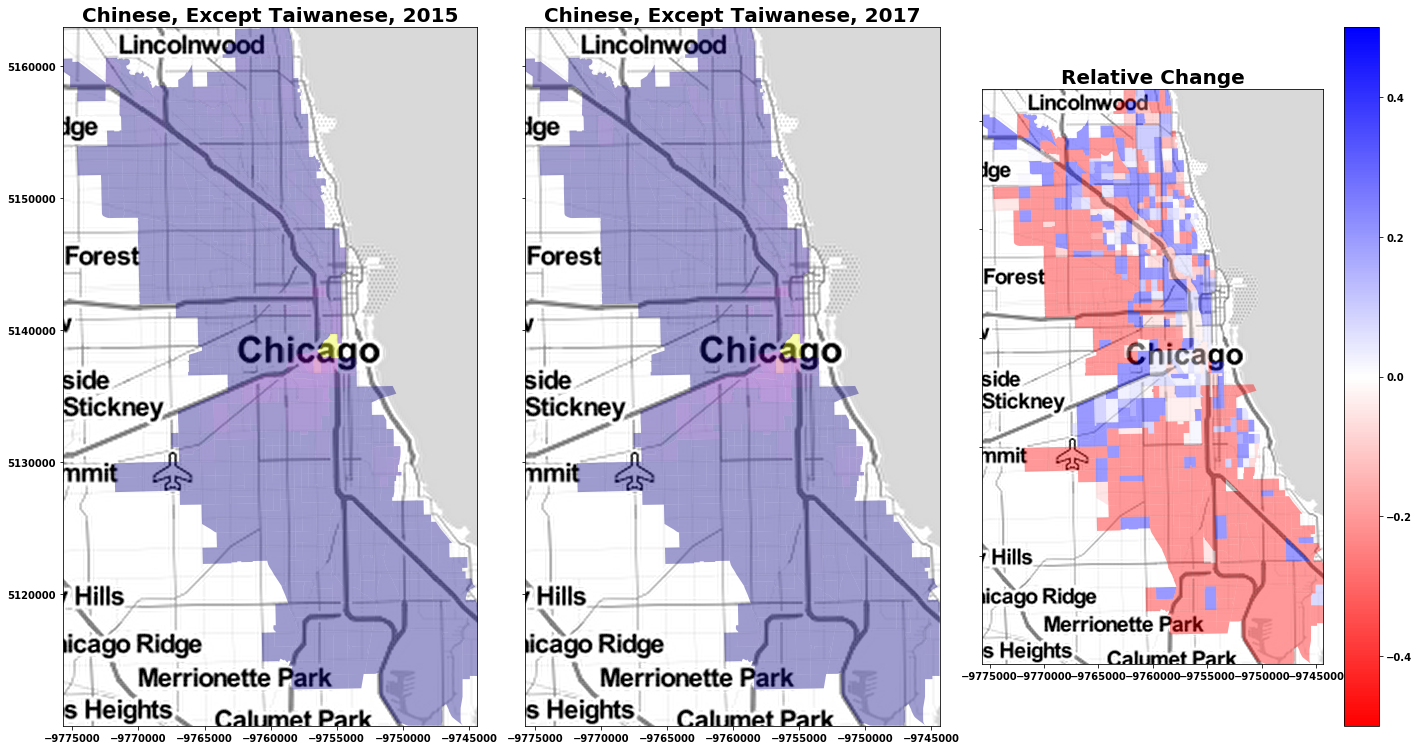

In [6]:
f,ax = plt.subplots(1,3, figsize=(20,10), sharex=True, sharey=True)
[ax_.imshow(chicago_basemap, extent=chicago_extent, interpolation='sinc') for ax_ in ax]
chicago.plot('B02018_007E', cmap='plasma', ax = ax[1], alpha=.4)
chicago_2015.plot('B02018_007E', cmap='plasma', ax = ax[0], alpha=.4)
chicago.merge(chicago_2015.drop('geometry',axis=1), on='GEOID', suffixes=('_2017', '_2015'))\
       .eval('pct_change = (B02018_007E_2017 - B02018_007E_2015)/(B02018_007E_2015)')\
       .plot('pct_change', cmap='bwr_r', ax=ax[2], alpha=.4, vmin=-.5, vmax=.5, legend=True)
f.tight_layout()
ax[0].axis(chicago.total_bounds[[0,2,1,3]])
ax[0].set_title('Chinese, Except Taiwanese, 2015', fontsize=20)
ax[1].set_title('Chinese, Except Taiwanese, 2017', fontsize=20)
ax[2].set_title('Relative Change', fontsize=20)

In [7]:
chicago = chicago.merge(chicago_2015.drop('geometry',axis=1), on='GEOID', suffixes=('_2017', '_2015'))

In [8]:
ca_boundaries = gpd.read_file("Boundaries - Community Areas (current).geojson")
ca_boundaries['area_num_1'] = ca_boundaries.apply(lambda x: int(x['area_num_1']), axis=1)

In [14]:
community_area = pd.read_excel("2010 Tract to Community Area Equivalency File.xlsx")

In [15]:
chicago['TRACT'] = chicago.apply(lambda x: int(x['tract_2017']), axis=1)
chicago = chicago.merge(community_area, on='TRACT')
chicago = chicago.merge(ca_boundaries.drop('geometry',axis=1), left_on='CHGOCA', right_on='area_num_1')
ca_totals = chicago.groupby('community')['B02018_001E_2017', 'B02018_001E_2015'].sum()
ca_totals = ca_totals.sort_values(by='B02018_001E_2017', ascending=False)
ca_totals = ca_totals.reset_index()
top_10 = ca_totals[:11]

In [28]:
cas = list(top_10.community)

fig = go.Figure(data=[
    go.Bar(name='2015', x=cas, y=list(top_10.B02018_001E_2015), marker_color='indianred'),
    go.Bar(name='2017', x=cas, y=list(top_10.B02018_001E_2017), marker_color='lightsalmon')
])
# Change the bar mode
fig.update_layout(barmode='group', title_text='Chinese, Except Taiwanese Population by Community Area')
fig.show()

In [67]:
fb_china = products.ACS(2017).from_place('Chicago, IL', level='tract', variables=['B05006_049'])

Matched: Chicago, IL to Chicago city within layer Incorporated Places


In [68]:
for year in [2015, 2013]:
    prev_year = products.ACS(year).from_place('Chicago, IL', level='tract', variables=['B05006_049'])
    suffix = "_" + str(year)[-2:]
    fb_china = fb_china.merge(prev_year.drop('geometry',axis=1), on='GEOID', suffixes=("", suffix))

Matched: Chicago, IL to Chicago city within layer Incorporated Places
Matched: Chicago, IL to Chicago city within layer Incorporated Places


In [69]:
def pct_change(x):
    if x['B05006_049E'] > 0:
        return (x['B05006_049E'] - x['B05006_049E_13']) / x['B05006_049E']
    else:
        return 0

fb_china['pct_change'] = fb_china.apply(lambda x: pct_change(x), axis=1)

Text(0.5, 1, 'Relative Change')

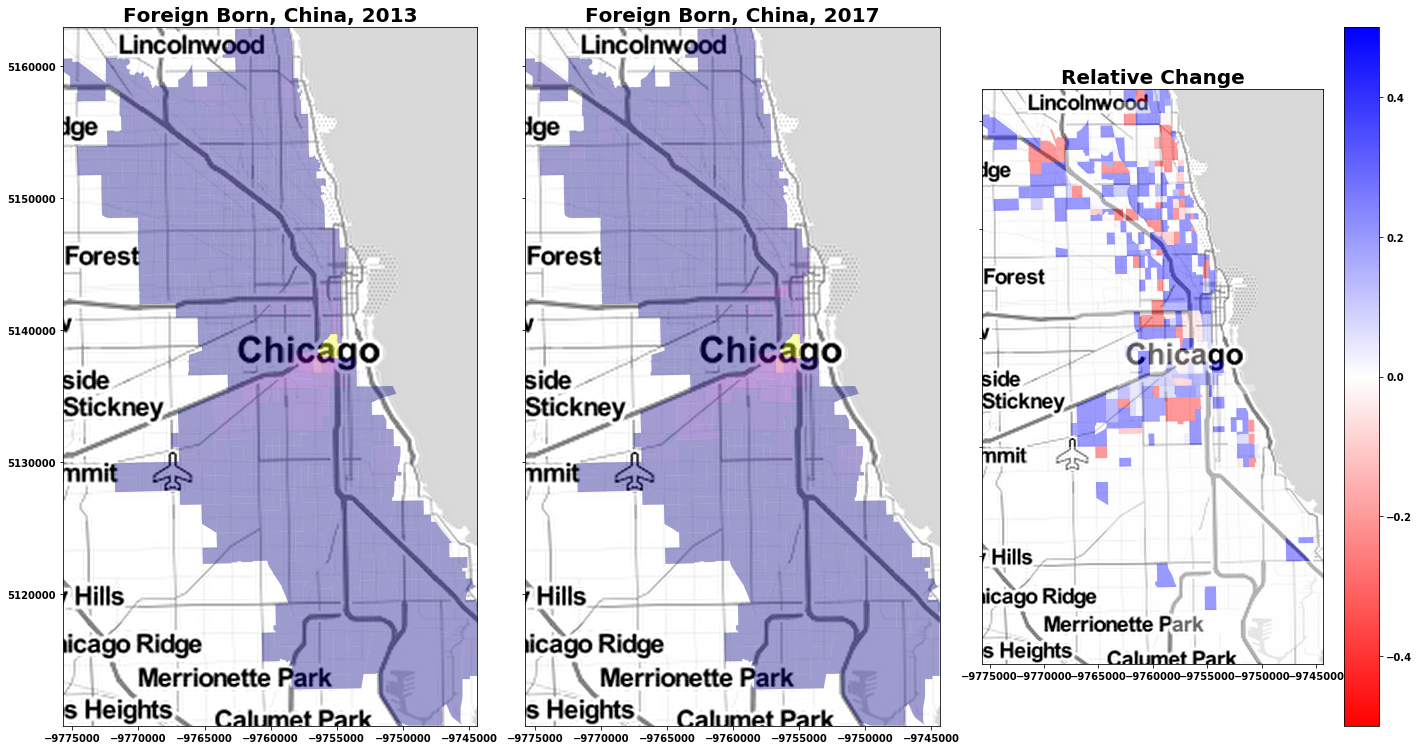

In [75]:
f,ax = plt.subplots(1,3, figsize=(20,10), sharex=True, sharey=True)
[ax_.imshow(chicago_basemap, extent=chicago_extent, interpolation='sinc') for ax_ in ax]
fb_china.plot('B05006_049E', cmap='plasma', ax = ax[1], alpha=.4)
fb_china.plot('B05006_049E_13', cmap='plasma', ax = ax[0], alpha=.4)
fb_china.plot('pct_change', cmap='bwr_r', ax=ax[2], alpha=.4, vmin=-.5, vmax=.5, legend=True)
f.tight_layout()
ax[0].axis(chicago.total_bounds[[0,2,1,3]])
ax[0].set_title('Foreign Born, China, 2013', fontsize=20)
ax[1].set_title('Foreign Born, China, 2017', fontsize=20)
ax[2].set_title('Relative Change', fontsize=20)

In [76]:
fb_china.head()

GEOID                                           geometry  \
0  17031250700  POLYGON ((-9770053.85 5147337.47, -9770049.4 5...   
1  17031190800  POLYGON ((-9768999.99 5150708.88, -9768945.220...   
2  17031191100  POLYGON ((-9768969.49 5149617.81, -9768914.609...   
3  17031251000  POLYGON ((-9768109.43 5146359.71, -9768055 514...   
4  17031620300  POLYGON ((-9766947.699999999 5130032.71, -9766...   

   B05006_049E state county   tract  B05006_049E_15 state_15 county_15  \
0          0.0    17    031  250700             0.0       17       031   
1          0.0    17    031  190800             0.0       17       031   
2          0.0    17    031  191100             0.0       17       031   
3          0.0    17    031  251000             0.0       17       031   
4          0.0    17    031  620300            47.0       17       031   

  tract_15  B05006_049E_13 state_13 county_13 tract_13  pct_change  
0   250700             0.0       17       031   250700         0.0  
1   190800             0.0       17       031   190800         0.0  
2   191100             0.0       17       031   191100         0.0  
3   251000             0.0       17       031   251000         0.0  
4   620300            61.0       17       031   620300         0.0

In [80]:
def top_10_cas(chicago, columns):
    chicago['TRACT'] = chicago.apply(lambda x: int(x['tract']), axis=1)
    chicago = chicago.merge(community_area, on='TRACT')
    chicago = chicago.merge(ca_boundaries.drop('geometry',axis=1), left_on='CHGOCA', right_on='area_num_1')
    ca_totals = chicago.groupby('community')[columns[0], columns[1]].sum()
    ca_totals = ca_totals.sort_values(by=columns[0], ascending=False)
    ca_totals = ca_totals.reset_index()
    top_10 = ca_totals[:11]
    return top_10

In [81]:
top_10_fb = top_10_cas(fb_china, ('B05006_049E', 'B05006_049E_13'))

In [84]:
cas = list(top_10_fb.community)

fig = go.Figure(data=[
    go.Bar(name='2013', x=cas, y=list(top_10_fb.B05006_049E_13), marker_color='indianred'),
    go.Bar(name='2017', x=cas, y=list(top_10_fb.B05006_049E), marker_color='lightsalmon')
])
# Change the bar mode
fig.update_layout(barmode='group', title_text='Foreign Born, China, by Community Area')
fig.show()